In [13]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pathlib

def read_yaml(file_path):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
    return data['names']

def read_labels(label_path, black_list, transition_map, filter_classes, transfer_classes):
    black_list = []
    transition_map = []
    filter_classes = []
    transfer_classes = []
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    labels = []
    remove = True
    for line in lines:
        result = list(map(float, line.strip().split()))
        if len(result) > 5:
            minX = min(result[1::2])
            minY = min(result[2::2])
            maxX = max(result[1::2])
            maxY = max(result[2::2])
            class_id = int(result[0])
            width = maxX - minX
            height = maxY - minY
            if (class_id in black_list):
                return None
            if (class_id in transition_map):
                class_id = transition_map.get(class_id)
            if (class_id not in filter_classes):
                remove = False
            if (width > 0.4 or height > 0.4 or width < 0.01 or height < 0.01):
                return None
            if (class_id in transfer_classes):
                class_id = transfer_classes.get(class_id)
            labels.append({
                'class_id': class_id,
                'x': (maxX + minX) / 2,
                'y': (maxY + minY),
                'width': width,
                'height': height
            })
            continue
        if len(result) < 5:
            print("WARNING:" + result)
            continue
        class_id, x, y, width, height = result
        class_id = int(class_id)
        if (class_id in black_list):
            return None
        if (class_id in transition_map):
            class_id = transition_map.get(class_id)
        if (class_id not in filter_classes):
            remove = False
        if (width > 0.4 or height > 0.4 or width < 0.01 or height < 0.01):
            return None
        if (class_id in transfer_classes):
            class_id = transfer_classes.get(class_id)
        labels.append({
            'class_id': class_id,
            'x': x,
            'y': y,
            'width': width,
            'height': height
        })
    if (remove):
        return None

    label_str = '\n'.join(map(lambda l: f"{l['class_id']} {l['x']} {l['y']} {l['width']} {l['height']}", labels))
    # with open(label_path, 'w') as f:
    #     f.write(label_str)
    return labels

class_dist_all = []
obj_sizes_all = []
obj_per_img_all = []

def analyze_dataset(root_folder, black_list, transition_map, filter_classes, transfer_classes):
    global class_dist_all
    global obj_sizes_all
    global obj_per_img_all
    count_files = 0
    # class_names = read_yaml(os.path.join(root_folder, 'data.yaml'))
    class_names = ['bus', 'car', 'motorbike', 'person', 'bicycle', 'truck']
    
    class_distribution = defaultdict(int)
    object_sizes = []
    objects_per_image = []

    for split in ['train', 'test', 'valid']:
        images_folder = os.path.join(root_folder, split, 'images')
        labels_folder = os.path.join(root_folder, split, 'labels')

        image_files = os.listdir(images_folder)
        for image_file in image_files:
            image_path = os.path.join(images_folder, image_file)
            label_path = os.path.join(labels_folder, image_file.replace('.jpg', '.txt'))
            
            file = pathlib.Path(label_path)

            if not file.exists():
                os.remove(image_path)
                print(image_path)
                continue

            image = cv2.imread(image_path)
            labels = read_labels(label_path, black_list, transition_map, filter_classes, transfer_classes)
            if (labels is None):
                print('HOW??')
                # os.remove(image_path)
                # os.remove(label_path)
                continue
            count_files += 1
            objects_per_image.append(len(labels))
            for label in labels:
                class_id = label['class_id']
                class_name = class_names[class_id]
                class_distribution[class_name] += 1
                
                width = label['width']
                height = label['height']
                object_sizes.append((width, height))
            

    class_dist_all.append(class_distribution)
    obj_sizes_all.append(object_sizes)
    obj_per_img_all.append(objects_per_image)
    print(count_files)

# 'bus', 'car', 'motorbike', 'person', 'bicycle', 'truck'

analyze_dataset('vd/', [4], {}, [1, 2, 3], {})
analyze_dataset('ssli/', [6], {}, [2, 3, 4], {0: 4, 1: 0, 2: 1, 3: 2, 4: 3})
analyze_dataset('sv/', [], {}, [2, 3, 4], {0: 4, 1: 0, 2: 1, 3: 2, 4: 3})
analyze_dataset('enye/', [0, 1, 3, 4, 9], {10: 8, 11: 6, 13: 12}, [6, 7, 8], {2: 4, 5: 0, 6: 1, 7: 2, 8: 3, 12: 5})

106
39
2023
1401


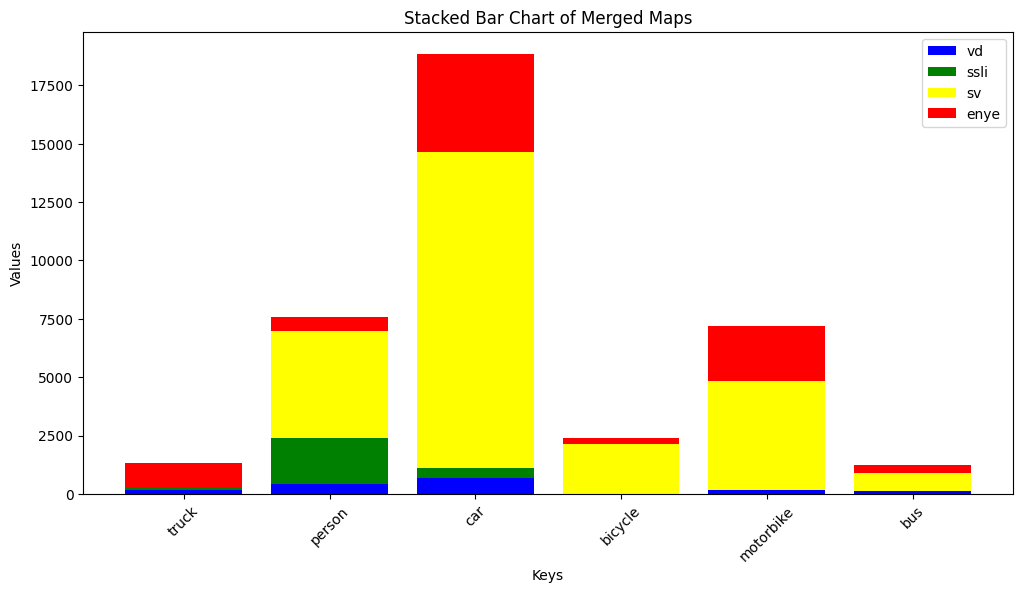

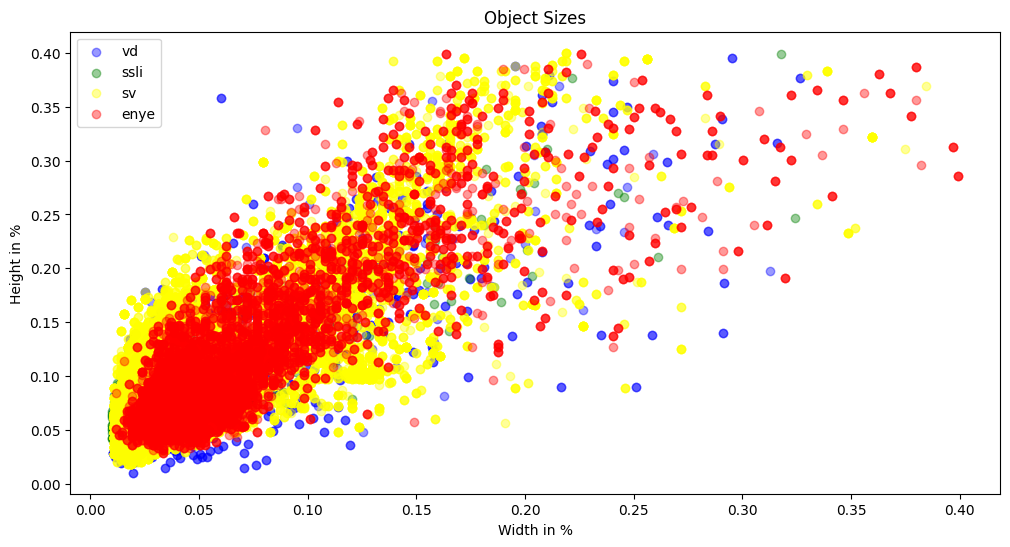

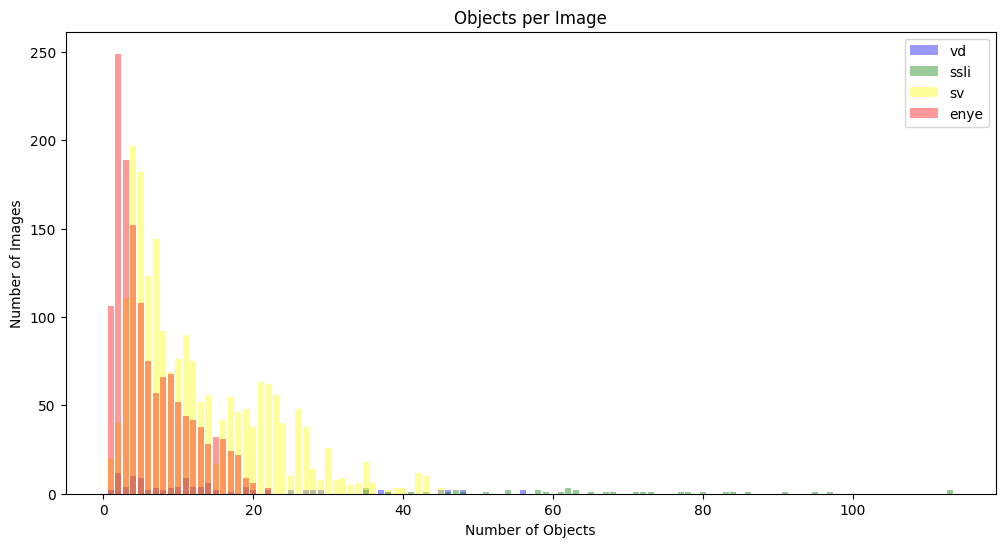

In [14]:
from collections import Counter

def merge_maps(maps):
    result = defaultdict(list)
    
    all_keys = set()
    for m in maps:
        all_keys.update(m.keys())
    
    for key in all_keys:
        for m in maps:
            result[key].append(m.get(key, 0))
    
    return result

def plot_stacked_bar(merged_map):
    colors = ['blue', 'green', 'yellow', 'red']
    labels = ['vd', 'ssli', 'sv', 'enye']
    
    keys = list(merged_map.keys())
    values = list(merged_map.values())
    num_maps = len(values[0])
    
    plt.figure(figsize=(12, 6))
    bottom = [0] * len(keys)
    for i in range(num_maps):
        plt.bar(keys, [v[i] for v in values], bottom=bottom, label=labels[i], color=colors[i])
        bottom = [bottom[j] + values[j][i] for j in range(len(keys))]
    
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Stacked Bar Chart of Merged Maps')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

def plot_class_distribution(classes_data):
    plot_stacked_bar(merge_maps(classes_data))

def plot_object_sizes(object_sizes):
    colors = ['blue', 'green', 'yellow', 'red']
    labels = ['vd', 'ssli', 'sv', 'enye']
    
    plt.figure(figsize=(12, 6))
    for i in range(4):
        widths, heights = zip(*(object_sizes[i]))
        plt.scatter(widths, heights, alpha=0.4, color=colors[i], label=labels[i])
    plt.xlabel('Width in %')
    plt.ylabel('Height in %')
    plt.title('Object Sizes')
    plt.legend()
    plt.show()

def plot_objects_per_image(objects_per_image):
    colors = ['blue', 'green', 'yellow', 'red']
    labels = ['vd', 'ssli', 'sv', 'enye']
    
    plt.figure(figsize=(12, 6))
    for i in range(4):
        counter = Counter(objects_per_image[i])
        elements = list(counter.keys())
        counts = list(counter.values())
        plt.bar(elements, counts, alpha=0.4, color=colors[i], label=labels[i])
    plt.xlabel('Number of Objects')
    plt.ylabel('Number of Images')
    plt.title('Objects per Image')
    plt.legend()
    plt.show()

plot_class_distribution(class_dist_all)
plot_object_sizes(obj_sizes_all)
plot_objects_per_image(obj_per_img_all)

In [12]:
import shutil

ds_merged = 'merged_ds/'

os.makedirs(os.path.join(ds_merged, 'train', 'images'))
os.makedirs(os.path.join(ds_merged, 'test', 'images'))
os.makedirs(os.path.join(ds_merged, 'valid', 'images'))
os.makedirs(os.path.join(ds_merged, 'train', 'labels'))
os.makedirs(os.path.join(ds_merged, 'test', 'labels'))
os.makedirs(os.path.join(ds_merged, 'valid', 'labels'))

for ds in ['vd/', 'ssli/', 'sv/', 'enye/']:
    for split in ['train', 'test', 'valid']:
        images_folder = os.path.join(ds, split, 'images')
        labels_folder = os.path.join(ds, split, 'labels')
        new_image_folder = os.path.join(ds_merged, split, 'images')
        new_label_folder = os.path.join(ds_merged, split, 'labels')

        image_files = os.listdir(images_folder)
        for image_file in image_files:
            image_path = os.path.join(images_folder, image_file)
            label_path = os.path.join(labels_folder, image_file.replace('.jpg', '.txt'))
            
            shutil.copy(image_path, new_image_folder)
            shutil.copy(label_path, new_label_folder)